In [14]:
import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn import metrics
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
import scipy.stats as stats
from scipy.stats import boxcox, normaltest
from sklearn.metrics import mean_squared_error
import re
% matplotlib inline
colors = ['#0d6fdb', '#01c8a9', '#3c188d', '#8daab3', '#dbe2ee', '#57758c', 
          '#1cec94', '#61f48d', '#c7f3d7', '#c7f3d7']

sns.set_style('dark',{'axes.spines.bottom': False,
 'axes.spines.left': False,
 'axes.spines.right': False,
 'axes.spines.top': False,
})
sns.set_palette(colors)
sns.set()



In [15]:
#Seperate script used to clean scraped data and Kaggle dataset
frame = pd.read_csv('cleaner_undies.csv', index_col = [0], header=0)
frame['no_attributes'] = frame['style_attributes'].apply(lambda x: x==0)
frame['number_sizes'] = frame['available_size'].apply(lambda x:len(x.split()))
frame['num_distinct_colors'] = frame.groupby(['product_name']).color.transform(lambda grp: len(set(grp)))
frame['mrp'] = np.log(frame['mrp'])

X=patsy.dmatrix('brand_name',data=frame,return_type='dataframe')
frame2 = frame.join(X)
frame3 = frame2.join(pd.get_dummies(drop_first=True, data=frame2.product_category))
frame4 = frame3.join(pd.get_dummies(drop_first=True, data=frame3.retailer))
del frame3
frame4 = frame4.drop(['color', 'available_size', 'total_sizes', 'style_attributes', 
                 'retailer', 'product_category', 'brand_name', 'pdp_url', 'product_name', 
                 'rating', 'no_attributes', 'brand_name[T.AERIE]', 'brand_name[T.Calvin Klein]', 
                 'brand_name[T.HankyPanky]', 'brand_name[T.Vanity Fair]', 'brand_name[T.Wacoal]'],1)
frame4.head()

/Users/chelan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,mrp,review_count,number_sizes,num_distinct_colors,Intercept,Socks,Swimsuit,Underwear,bra,Amazon US,Btemptd US,Calvin Klein US,Hankypanky US,Macys US,Nordstrom US,Topshop US,Victoriassecret US
0,2.525729,8.0,6,6,1.0,0,0,1,0,0,0,0,0,0,0,0,0
1,2.525729,8.0,6,6,1.0,0,0,1,0,0,0,0,0,0,0,0,0
2,2.525729,8.0,6,6,1.0,0,0,1,0,0,0,0,0,0,0,0,0
3,2.525729,8.0,6,6,1.0,0,0,1,0,0,0,0,0,0,0,0,0
4,2.525729,8.0,6,6,1.0,0,0,1,0,0,0,0,0,0,0,0,0


In [16]:
scrape_frame = pd.read_csv('cleaned_nordstrom.csv')
scrape_frame['Amazon US'] = 0
scrape_frame['Btemptd US'] = 0
scrape_frame['Calvin Klein US'] = 0
scrape_frame['Hankypanky US'] = 0
scrape_frame['Macys US'] = 0
scrape_frame['Nordstrom US'] = 1
scrape_frame['Topshop US'] = 0
scrape_frame['Victoriassecret US'] = 0
scrape_frame['Swimsuit'] = 0
scrape_frame['mrp'] = scrape_frame['mrp'].apply(lambda x: re.sub('[^0-9,\.]',' ',x))
scrape_frame.dropna(inplace = True)
scrape_frame['mrp'] = scrape_frame['mrp'].apply(lambda x: float(x))
scrape_frame['mrp'] = np.log(scrape_frame['mrp'])

scraped_X=patsy.dmatrix('product_category',data=scrape_frame,return_type='dataframe')
scrape_frame = scrape_frame.join(scraped_X)
scrape_frame.head()


,product_name,mrp,review_count,product_category,number_sizes,num_distinct_colors,Amazon US,Btemptd US,Calvin Klein US,Hankypanky US,Macys US,Nordstrom US,Topshop US,Victoriassecret US,Swimsuit,Intercept,product_category[T.Lingerie],product_category[T.Socks],product_category[T.Underwear],product_category[T.bra]
0,Oh La La Cheri Crisscross Lace Thong Bodysuit ...,3.401197,3.0,Lingerie,2,1.0,0,0,0,0,0,1,0,0,0,1.0,1.0,0.0,0.0,0.0
1,Oh La La Cheri Lace-Up Thong Teddy (Plus Size),1.974081,12.0,Lingerie,2,1.0,0,0,0,0,0,1,0,0,0,1.0,1.0,0.0,0.0,0.0
2,Oh La La Cheri Plunge Keyhole Lace Teddy (Plus...,3.218476,27.0,Lingerie,2,1.0,0,0,0,0,0,1,0,0,0,1.0,1.0,0.0,0.0,0.0
3,Oh La La Cheri Plunge Neck Thong Teddy (Plus S...,2.771964,0.0,Lingerie,2,2.0,0,0,0,0,0,1,0,0,0,1.0,1.0,0.0,0.0,0.0
4,Oh La La Cheri Strappy Lace Teddy (Plus Size),2.564180,0.0,Lingerie,2,1.0,0,0,0,0,0,1,0,0,0,1.0,1.0,0.0,0.0,0.0


In [17]:
cols = [ 'mrp',
 'review_count',
 'number_sizes',
 'num_distinct_colors',
 'Intercept',
 'product_category[T.Socks]',
 'Swimsuit',
 'product_category[T.Underwear]',
 'product_category[T.bra]',
 'Amazon US',
 'Btemptd US',
 'Calvin Klein US',
 'Hankypanky US',
 'Macys US',
 'Nordstrom US',
 'Topshop US',
 'Victoriassecret US',]

scrape_frame = scrape_frame[cols]

scrape_frame.rename(columns={'product_category[T.Socks]': 'Socks',
                  'product_category[T.Lingerie]': 'Lingerie',
                  'product_category[T.Underwear]': 'Underwear',
                  'product_category[T.bra]': 'bra'}, inplace=True)



In [18]:
scrape_frame.head()

,mrp,review_count,number_sizes,num_distinct_colors,Intercept,Socks,Swimsuit,Underwear,bra,Amazon US,Btemptd US,Calvin Klein US,Hankypanky US,Macys US,Nordstrom US,Topshop US,Victoriassecret US
0,3.401197,3.0,2,1.0,1.0,0.0,0,0.0,0.0,0,0,0,0,0,1,0,0
1,1.974081,12.0,2,1.0,1.0,0.0,0,0.0,0.0,0,0,0,0,0,1,0,0
2,3.218476,27.0,2,1.0,1.0,0.0,0,0.0,0.0,0,0,0,0,0,1,0,0
3,2.771964,0.0,2,2.0,1.0,0.0,0,0.0,0.0,0,0,0,0,0,1,0,0
4,2.564180,0.0,2,1.0,1.0,0.0,0,0.0,0.0,0,0,0,0,0,1,0,0


In [19]:
model_frame = frame4.append(scrape_frame)
model_frame.head()

,mrp,review_count,number_sizes,num_distinct_colors,Intercept,Socks,Swimsuit,Underwear,bra,Amazon US,Btemptd US,Calvin Klein US,Hankypanky US,Macys US,Nordstrom US,Topshop US,Victoriassecret US
0,2.525729,8.0,6,6.0,1.0,0.0,0,1.0,0.0,0,0,0,0,0,0,0,0
1,2.525729,8.0,6,6.0,1.0,0.0,0,1.0,0.0,0,0,0,0,0,0,0,0
2,2.525729,8.0,6,6.0,1.0,0.0,0,1.0,0.0,0,0,0,0,0,0,0,0
3,2.525729,8.0,6,6.0,1.0,0.0,0,1.0,0.0,0,0,0,0,0,0,0,0
4,2.525729,8.0,6,6.0,1.0,0.0,0,1.0,0.0,0,0,0,0,0,0,0,0


/Users/chelan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


count    613143.000000
mean         36.497651
std          20.922941
min           6.000000
25%          24.500000
50%          35.000000
75%          47.955000
max         721.448000
Name: mrp, dtype: float64

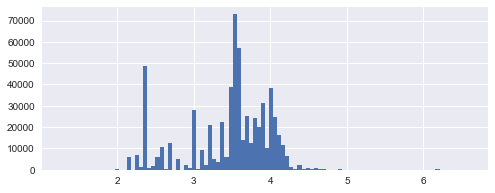

In [20]:
#Value of prices, no transformation
frame = pd.read_csv('cleaner_undies.csv', index_col = [0], header=0)
plt.figure(figsize=(8,3))
plt.hist(model_frame.mrp,bins=100)
frame['mrp'].describe()

count    614122.000000
mean          3.461120
std           0.551645
min           1.280934
25%           3.198673
50%           3.555348
75%           3.839452
max           6.581260
Name: mrp, dtype: float64

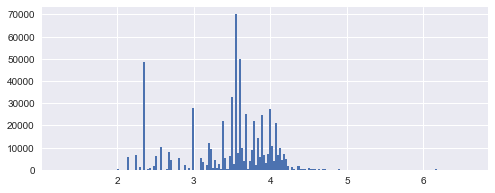

In [21]:
#Log Transformed
plt.figure(figsize=(8,3))
plt.hist(model_frame.mrp,bins=200)
model_frame['mrp'].describe()

In [22]:
#Correlations 
sample = model_frame.sample(n= 1000) #So this doesn't crash 

sample.corr()

,mrp,review_count,number_sizes,num_distinct_colors,Intercept,Socks,Swimsuit,Underwear,bra,Amazon US,Btemptd US,Calvin Klein US,Hankypanky US,Macys US,Nordstrom US,Topshop US,Victoriassecret US
mrp,1.000000,-0.042804,0.188707,0.164320,NaN,-0.053769,0.041865,-0.617385,0.605153,0.148049,-0.029386,-0.126516,0.063600,-0.019461,-0.024012,0.008482,0.012801
review_count,-0.042804,1.000000,-0.020324,-0.061206,NaN,-0.002239,-0.005943,0.065830,-0.042410,-0.017723,-0.006356,-0.006356,-0.019418,-0.019269,-0.011099,-0.004485,0.044686
number_sizes,0.188707,-0.020324,1.000000,-0.167051,NaN,-0.009085,-0.013936,-0.100261,0.092051,0.789183,-0.025786,-0.025786,-0.020790,0.006602,0.070730,-0.018197,-0.454804
num_distinct_colors,0.164320,-0.061206,-0.167051,1.000000,NaN,-0.033001,-0.066937,-0.134277,0.294508,-0.124331,-0.069315,-0.065116,-0.113458,-0.230533,-0.127880,-0.073213,0.394190
Intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Socks,-0.053769,-0.002239,-0.009085,-0.033001,NaN,1.000000,-0.002656,-0.017145,-0.044677,-0.007922,-0.002841,0.352313,-0.008680,-0.008613,-0.004961,-0.002005,-0.050113
Swimsuit,0.041865,-0.005943,-0.013936,-0.066937,NaN,-0.002656,1.000000,-0.045499,-0.118560,-0.021024,-0.007540,-0.007540,-0.023035,-0.022857,-0.013166,-0.005321,0.026438
Underwear,-0.617385,0.065830,-0.100261,-0.134277,NaN,-0.017145,-0.045499,1.000000,-0.765221,-0.044508,0.138919,0.112121,0.403353,-0.147527,0.039806,-0.034342,-0.229013
bra,0.605153,-0.042410,0.092051,0.294508,NaN,-0.044677,-0.118560,-0.765221,1.000000,0.096338,-0.103009,-0.103009,-0.320931,-0.250579,-0.166020,-0.089488,0.412438
Amazon US,0.148049,-0.017723,0.789183,-0.124331,NaN,-0.007922,-0.021024,-0.044508,0.096338,1.000000,-0.022486,-0.022486,-0.068697,-0.068168,-0.039266,-0.015868,-0.396608


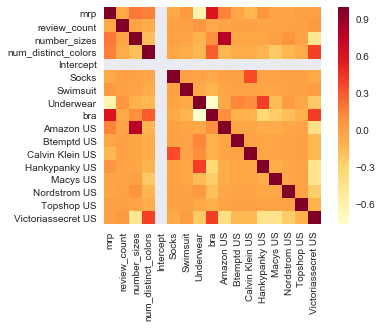

In [23]:
sns.heatmap(sample.corr(), square=True, cmap='YlOrRd')

In [24]:
#Test Train Split

y=model_frame['mrp']
X=model_frame.drop(['mrp', 'Intercept', 'review_count'],1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


X_scaler = preprocessing.StandardScaler(copy=False).fit(X_train)
X_train = X_scaler.transform(X_train)
X_test=X_scaler.transform(X_test)
X_train=pd.DataFrame(X_train,columns=X.columns)
X_test=pd.DataFrame(X_test,columns=X.columns)

y_train=pd.DataFrame(y_train,columns=['mrp'])
y_test=pd.DataFrame(y_test,columns=['mrp'])

In [25]:
#Lasso Model
param_grid = {
    'alpha': [3.46e-4, 3.47e-4, 3.48e-4, 3.49e-4, 3.50e-4, 3.51e-4],
    'max_iter': [1000, 2000, 4000]
}
lasso = Lasso()
grid = GridSearchCV(lasso, param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.000346, 0.000347, 0.000348, 0.000349, 0.00035, 0.000351], 'max_iter': [1000, 2000, 4000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [26]:
grid.best_params_

{'alpha': 0.000346, 'max_iter': 1000}

In [27]:
lasso = Lasso(alpha=0.000346)
model = lasso.fit(X_train, y_train)
zipped=zip(X.columns, model.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)
features

[('Hankypanky US', 0.2486932856015562),
 ('bra', 0.1349760351936339),
 ('Amazon US', 0.09376246988351862),
 ('Victoriassecret US', 0.06686253843953409),
 ('Nordstrom US', 0.0631632907707365),
 ('num_distinct_colors', 0.04407107487229907),
 ('Macys US', 0.04188384125008767),
 ('Btemptd US', 0.031295839690672025),
 ('Swimsuit', 0.029870714998402978),
 ('number_sizes', 0.02603319818800493),
 ('Calvin Klein US', 0.021230806028224355),
 ('Topshop US', -0.004728909808288267),
 ('Socks', -0.012613191350336783),
 ('Underwear', -0.3143488739402743)]

In [28]:
model.score(X_train, y_train)

0.5830334496798253

In [29]:
mean_squared_error(y_train, model.predict(X_train))

0.12687183754438347

In [32]:
#Second Model
X_train['Amazon_Sizes'] = X_train['number_sizes']*X_train['Amazon US']
lasso = Lasso(alpha=0.000346)
model = lasso.fit(X_train, y_train)
zipped=zip(X_train.columns, model.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)
features

[('Hankypanky US', 0.2601434747298174),
 ('number_sizes', 0.14294014872471356),
 ('bra', 0.13182026986851486),
 ('Amazon US', 0.11826993370818416),
 ('Victoriassecret US', 0.10091170443933757),
 ('Nordstrom US', 0.06396713743758968),
 ('Macys US', 0.050686503673635794),
 ('num_distinct_colors', 0.04481506826023046),
 ('Btemptd US', 0.03694864701016432),
 ('Swimsuit', 0.029480046608053593),
 ('Calvin Klein US', 0.02777773336884011),
 ('Topshop US', 0.0),
 ('Socks', -0.011763325515182667),
 ('Amazon_Sizes', -0.0316292323077551),
 ('Underwear', -0.314991371954405)]

In [33]:
model.score(X_train, y_train)

0.5862034519006096

In [34]:
#Model 3
X_train['VS_bra'] = X_train['bra']*X_train['Victoriassecret US']
lasso = Lasso(alpha=0.000346)
model = lasso.fit(X_train, y_train)
zipped=zip(X_train.columns, model.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)
features

[('Hankypanky US', 0.25035946130626224),
 ('number_sizes', 0.17766605589210993),
 ('bra', 0.14275553871509203),
 ('Victoriassecret US', 0.12429702574570715),
 ('Amazon US', 0.12251811907585397),
 ('Nordstrom US', 0.05949836996431956),
 ('Macys US', 0.048518205146593725),
 ('VS_bra', 0.04115709588989132),
 ('num_distinct_colors', 0.03968602386847363),
 ('Btemptd US', 0.03518991134572718),
 ('Swimsuit', 0.033272543816856154),
 ('Calvin Klein US', 0.02713348438507443),
 ('Topshop US', -0.0015107259364240957),
 ('Socks', -0.011922882670568706),
 ('Amazon_Sizes', -0.03634795011130499),
 ('Underwear', -0.302027137904161)]

In [35]:
model.score(X_train, y_train)

0.5900220653817805

In [36]:
mean_squared_error(y_train, model.predict(X_train))

0.12474538755620637

In [37]:
import diagnostic

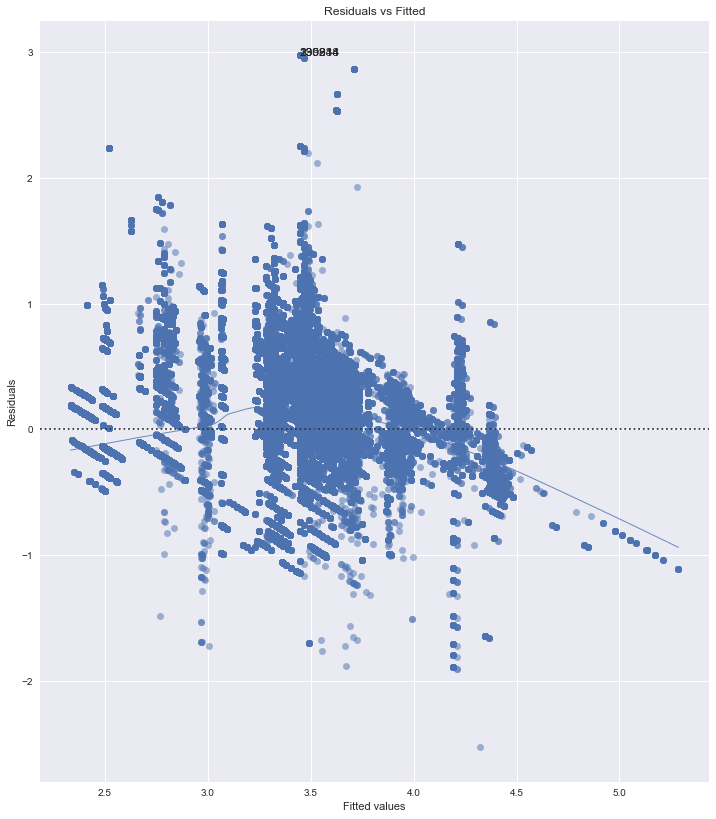

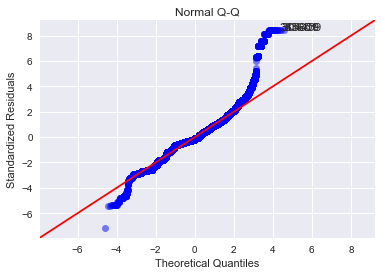

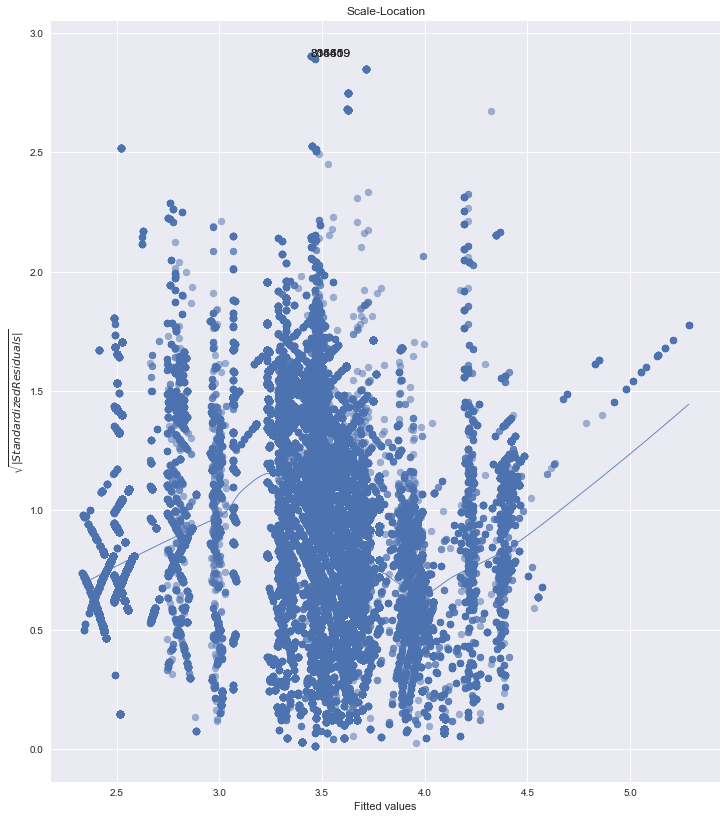

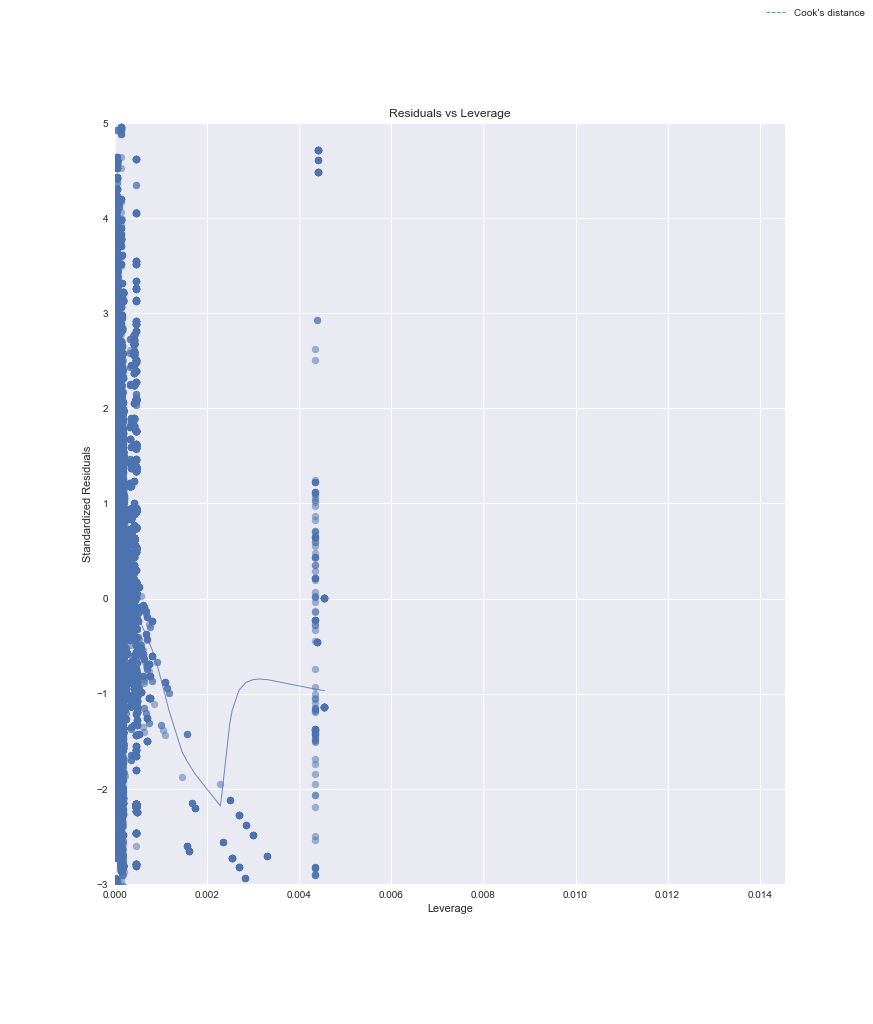

In [38]:
y_train.index = X_train.index
diagnostic.diagnostic_plots(X_train, y_train)